In [1]:
import pickle
import pandas as pd
import os
from glob import glob
import tqdm
import numpy as np
import torch
import json
import umap.umap_ as umap
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib
import plotly.graph_objects as go
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from sklearn.manifold import TSNE


/idiap/temp/ibmahmoud/miniconda3/envs/evolang/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
MAIN_DIR="/idiap/project/evolang/meerkats_imen/evolang_meerkats_calls_classification/workspace/"
DATA_DIR="/idiap/temp/ibmahmoud/s3prl/layer-specific-wavlm-mara/"

In [9]:
all_files=glob(DATA_DIR + "*.pkl", recursive=True)
with open(MAIN_DIR + 'src/data/class_to_index_mara.json') as f:
    class_to_index = json.load(f)
    

In [14]:
embeddings=np.empty((0,768))
labels=np.array(())
for emb in all_files:
    with open(emb,"rb") as handle:
        x=pd.read_pickle(emb)
        features_dict=pickle.load(handle)

    layer=features_dict["tfmr_Last"]
    result=torch.cat((torch.mean(layer,dim=0),torch.std(layer,dim=0)))
    filename=emb.split("/")[-1]
    class_name=filename.split(".")[0]
    label=class_to_index[class_name]
    
    
    break
    labels=np.append(labels,[label]*mean_layer.shape[0])
    embeddings=np.append(embeddings,mean_layer,axis=0)


torch.Size([5, 768])
torch.Size([1536])


KeyError: 'HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221163_wav___1_10_56_215'

In [5]:
result.shape

NameError: name 'result' is not defined

In [46]:
def umap_3Dplot(x,y,z,scat_labels, mycolors,outname=None, showlegend=True):
    """
    Function that creates (and saves) 3D plot from an
    input dataset, color-colored by the provided labels.

    Parameters
    ----------
    x : 1D numpy array (numeric) or list
        x coordinates of datapoints
                
    y: 1D numpy array (numeric) or list 
       y coordinates of datapoints

    z: 1D numpy array (numeric) or list 
       z coordinates of datapoints
    
    scat_labels: List-of-Strings
                 Datapoint labels
                     
    mycolors: String or List-of-Strings
              Seaborn color palette name (e.g. "Set2") or list of
              colors (Hex value strings) used for coloring datapoints
              (e.g. ["#FFEBCD","#0000FF",...])
                     
    outname: String
             Output filename at which plot will be saved
             No plot will be saved if outname is None
             (e.g. "my_folder/my_img.png")
             
    showlegend: Boolean
                Show legend if True, else don't
                
    Returns
    -------
    
    -
             
    """    
    labeltypes = sorted(list(set(scat_labels)))
    pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
    color_dict = dict(zip(labeltypes, pal))
    c = [color_dict[val] for val in scat_labels]
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    Axes3D.scatter(ax,
                    xs = x,
                    ys = y,
                    zs = z,
                    zdir='z',
                    s=20,
                    label = c,
                    c=c,
                    depthshade=False)

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_zlabel('UMAP3')
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')



    if showlegend: 
        scatters = []
        for label in labeltypes:
            scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
        
        ax.legend(scatters, labeltypes, numpoints = 1)
    
    if outname: plt.savefig(outname, facecolor="white")




In [21]:
umaps=umap.UMAP(n_components=3).fit_transform(embeddings)

In [48]:
distinct_colors_22 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                      '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                      '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                      '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                      '#ffffff', '#000000']

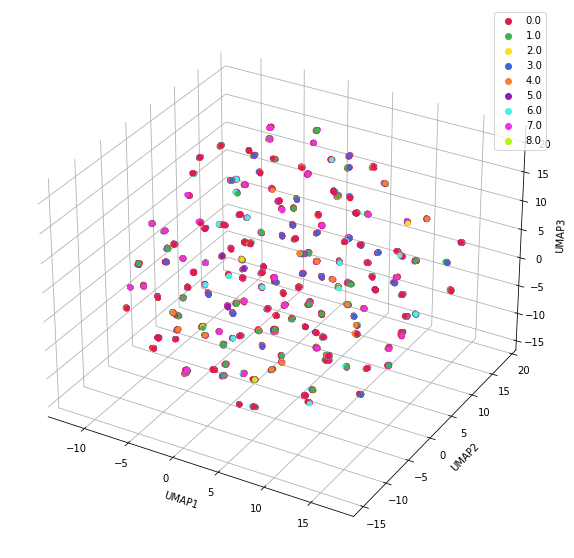

In [24]:
umap_3Dplot(umaps[:,0],umaps[:,1],umaps[:,2],scat_labels=labels,mycolors=distinct_colors_22,outname="umap_wavlm_allframes_marta.jpeg",showlegend=True)

TSNE

In [25]:
tsne=TSNE(n_components=2)
X_embedded=tsne.fit_transform(embeddings)

/idiap/temp/ibmahmoud/miniconda3/envs/evolang/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/idiap/temp/ibmahmoud/miniconda3/envs/evolang/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


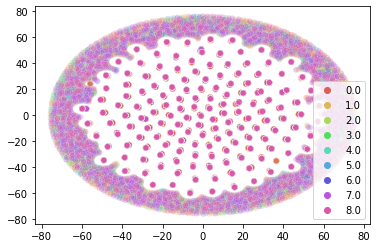

In [26]:
sns.scatterplot(
    x=X_embedded[:,0],
    y= X_embedded[:,1],
    hue=labels,
    palette=sns.color_palette("hls", 9),
    #data=pca_features,
    legend="full",
    alpha=0.3
)
plt.savefig("tsne_wavlm_marta_allframes.jpeg")

In [ ]:
embeddings.shape

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [8]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
X_train,X_test,y_train,y_test=train_test_split(embeddingsm,labelsm,test_size=0.2,random_state=42)


In [9]:
rf=RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [10]:
best_model=grid_search.best_estimator_
y_pred=best_model.predict(X_test)

In [14]:
print(len(np.where(y_pred != 5)[0]))

0


In [11]:
y_test

array([2., 2., 5., ..., 1., 2., 0.])

In [ ]:
print(len(np.where(y_pred != y_test)[0]))
print(len(np.where(y_test ==0)[0]))

In [ ]:
len(y_test)

Read Mara SSL 

In [19]:

all_files=glob("/idiap/temp/ibmahmoud/s3prl/test/" + "*.pkl", recursive=True)
with open(MAIN_DIR + 'src/data/class_to_index_mara.json') as f:
    class_to_index = json.load(f)

info_file=pd.read_csv("/idiap/project/evolang/meerkats_imen/evolang_meerkats_calls_classification/lib/mara-code/data/info_file.csv",sep=";")



In [20]:
print(len(all_files))

6428


In [41]:
embeddingsm=torch.empty(0,768*2)
#embeddingsm=embeddingsm[None,:]
labelsm=np.array(())
for emb in all_files:
    with open(emb,"rb") as handle:
        x=pd.read_pickle(emb)
        features_dict=pickle.load(handle)


    filename=emb.split("/")[-1].replace("pkl","wav")

    result = info_file.loc[info_file['filename'] == filename, 'label'].values[0]
    label=class_to_index[result]
    
    layer=features_dict["tfmr_Last"]
    result=torch.cat((torch.mean(layer,dim=0),torch.std(layer,dim=0)))

    labelsm=np.append(labelsm,label)
    embeddingsm=torch.cat((embeddingsm,result.unsqueeze(0)),dim=0)


In [43]:
print(embeddingsm.shape,labelsm.shape)

torch.Size([6428, 1536]) (6428,)


In [44]:
umaps=umap.UMAP(n_components=3).fit_transform(embeddingsm)

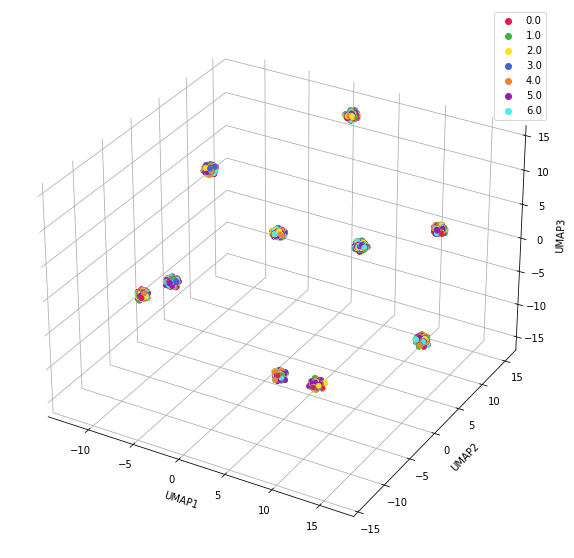

In [49]:
umap_3Dplot(umaps[:,0],umaps[:,1],umaps[:,2],scat_labels=labelsm,mycolors=distinct_colors_22,outname="umap_wavlm_allframes_marta.jpeg",showlegend=True)

In [50]:
tsne=TSNE(n_components=2)
X_embeddedm=tsne.fit_transform(embeddingsm)

/idiap/temp/ibmahmoud/miniconda3/envs/evolang/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/idiap/temp/ibmahmoud/miniconda3/envs/evolang/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


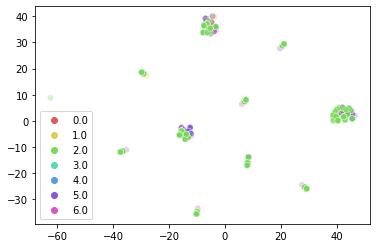

In [51]:
sns.scatterplot(
    x=X_embeddedm[:,0],
    y= X_embeddedm[:,1],
    hue=labelsm,
    palette=sns.color_palette("hls", 7),
    #data=pca_features,
    legend="full",
    alpha=0.3
)
plt.savefig("tsne_wavlm_mara_allframes.jpeg")